##Importing libraries

In [0]:
from pyspark.sql.types import *
import re
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

##Importing the source files

In [0]:
#Declaring variables for source files and extensions
#def declare_file():
Source_file1='clinicaltrial_2023'
Source_file2='pharma'
Source_zip_format_extension='.zip'
Source_file_format='.csv'
#declare_file()

##Cleaning the existing files in tmp folder

In [0]:
import os
os.environ['Source_file1'] = Source_file1
os.environ['Source_file2'] = Source_file2

In [0]:
def remove_files():
    dbutils.fs.rm("/FileStore/tables/" + Source_file1, True)
    dbutils.fs.rm("/FileStore/tables/" + Source_file2, True)
    print("Existing files removed in dbfs system")
remove_files()

Existing files removed in dbfs system


##Unzipping the file

In [0]:
def copy_files():
    dbutils.fs.cp("/FileStore/tables/" + Source_file1 + Source_zip_format_extension , "file:/tmp/")
    dbutils.fs.cp("/FileStore/tables/" + Source_file2 + Source_zip_format_extension , "file:/tmp/")
    print("Files Copied successully from dbfc to temp folder for processing!!")
copy_files()

Files Copied successully from dbfc to temp folder for processing!!


In [0]:
%sh
rm -r /tmp/$Source_file1|$Source_zip_format_extension
rm -r /tmp/$Source_file2|$Source_zip_format_extension

rm: cannot remove '/tmp/clinicaltrial_2023': No such file or directory
rm: cannot remove '/tmp/pharma': No such file or directory


In [0]:
%sh

unzip -d /tmp /tmp/$Source_file1
unzip -d /tmp /tmp/$Source_file2

Archive:  /tmp/clinicaltrial_2023.zip
  inflating: /tmp/clinicaltrial_2023.csv  
Archive:  /tmp/pharma.zip
  inflating: /tmp/pharma.csv         


In [0]:
def move_files():
    dbutils.fs.mv("file:/tmp/" + Source_file1+Source_file_format , "/FileStore/tables/" , True)
    dbutils.fs.mv("file:/tmp/" + Source_file2+Source_file_format , "/FileStore/tables/" , True)
move_files()

##Data Injestion

In [0]:
#def split_file():
delimiters1=["\t"]
df_clinical=spark.read.csv("/FileStore/tables/" + Source_file1 + Source_file_format,
                           sep=delimiters1,
                           header=True,
                           inferSchema=True)
    
rdd_clinical=df_clinical.rdd

print(f"{Source_file1} loaded successfully!!!")
    
df_Pharma=spark.read.csv("/FileStore/tables/" + Source_file2 + Source_file_format,
                         sep=',',
                         header=True,
                         inferSchema=True)
df_Pharma_rdd=df_Pharma.rdd
print(f"{Source_file2} loaded successfully!!!")

clinicaltrial_2023 loaded successfully!!!
pharma loaded successfully!!!


##Data Analysis and cleansing

In [0]:
#def create_dataframe():
Schema = StructType([
        StructField("Id", StringType()),
        StructField("StudyTitle", StringType()),
        StructField("Acronym", StringType()),
        StructField("Status", StringType()),
        StructField("Conditions", StringType()),
        StructField("Interventions", StringType()),
        StructField("Sponsor", StringType()),
        StructField("Collaborators", StringType()),
        StructField("Enrollment", StringType()),
        StructField("FunderType", StringType()),
        StructField("Type", StringType()),
        StructField("StudyDesign", StringType()),
        StructField("Start", StringType()),
        StructField("Completion", StringType())
        ])

RDD_raw = rdd_clinical.map(lambda x : (x[0].split('\t')))\
                     .map(lambda x : (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[-7],x[-6],x[-5],x[-4],x[-3],x[-2],x[-1]))\
                     .collect()
print("Source data converted to RDD Successfully!!!")

Source_Raw = spark.createDataFrame(RDD_raw, Schema)
Raw_file=sc.parallelize(RDD_raw)
df_raw=Raw_file.toDF()
print("Dataframe created for source file")

RDD_cleansed = rdd_clinical.map(lambda x : (x[0].replace('\"','').replace(',','').split('\t')))\
                           .filter(lambda x : x[0] is not None)\
                           .filter(lambda x : x[0]!='')\
                           .filter(lambda x : (x[0]!='NCT00146315'))\
                           .filter(lambda x : len(x[0])<=11)\
                           .map(lambda x : (x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13]))\
                           .collect()
print("Data Splitted and Cleansing done Successfully!!!")
Source_Transform = spark.createDataFrame(RDD_cleansed, Schema)
Transf=sc.parallelize(RDD_cleansed)
df_main=Transf.toDF()
print("Dataframe created for cleansed file")

Final_rdd=df_main.rdd
print("RDD for clinical cleansed data created successfully!!!")

Source data converted to RDD Successfully!!!
Dataframe created for source file
Data Splitted and Cleansing done Successfully!!!
Dataframe created for cleansed file
RDD for clinical cleansed data created successfully!!!


##Creating SQL tables

In [0]:
#def create_temp_views():
Source_Transform.createOrReplaceTempView("clinicaltrial_2023")
print("Temporary view of clinicaltrial_2023 created successfully!!!")
df_Pharma.createOrReplaceTempView("pharma")
print("Temporary view of pharma created successfully!!!")
#create_temp_views()

Temporary view of clinicaltrial_2023 created successfully!!!
Temporary view of pharma created successfully!!!


In [0]:
%sql
show tables;

create or replace table default.clinicaltrial_2023 as select * from clinicaltrial_2023;
create or replace table default.pharma as select * from pharma;

num_affected_rows,num_inserted_rows


##Exploratory Data Analysis

In [0]:
df_clinical.describe().display()

summary,"""Id Study Title Acronym Status Conditions Interventions Sponsor Collaborators Enrollment Funder Type Type Study Design Start Completion"",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"
count,483422
mean,null
stddev,null
min,"""NCT00000102 Congenital Adrenal Hyperplasia: Calcium Channels as Therapeutic Targets COMPLETED Congenital Adrenal Hyperplasia DRUG: Nifedipine National Center for Research Resources (NCRR) NIH INTERVENTIONAL Allocation: |Intervention Model: PARALLEL|Masking: DOUBLE|Primary Purpose: TREATMENT "",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"
max,"NCT06238115 Tirofiban for Reduction of Thromboembolic Events in Endovascular Unruptured Aneurysm Repair TEAR NOT_YET_RECRUITING Unruptured Intracranial Aneurysm|Flow Diverter|Stent-assisted Coiling|Thromboembolic Events DRUG: Tirofiban|DRUG: aspirin, clopidogrel Beijing Tiantan Hospital 190.0 OTHER INTERVENTIONAL Allocation: RANDOMIZED|Intervention Model: PARALLEL|Masking: SINGLE (OUTCOMES_ASSESSOR)|Primary Purpose: TREATMENT 2024-02-08 2025-06-01"


In [0]:
df_Pharma.describe().display()

summary,Company,Parent_Company,Penalty_Amount,Subtraction_From_Penalty,Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting,Penalty_Year,Penalty_Date,Offense_Group,Primary_Offense,Secondary_Offense,Description,Level_of_Government,Action_Type,Agency,Civil/Criminal,Prosecution_Agreement,Court,Case_ID,Private_Litigation_Case_Title,Lawsuit_Resolution,Facility_State,City,Address,Zip,NAICS_Code,NAICS_Translation,HQ_Country_of_Parent,HQ_State_of_Parent,Ownership_Structure,Parent_Company_Stock_Ticker,Major_Industry_of_Parent,Specific_Industry_of_Parent,Info_Source,Notes
count,968,968,968,968,968,968,968,968,968,160,670,968,968,937,968,22,34,198,33,32,500,199,124,142,120,103,965,533,966,722,968,968,965,61
mean,null,null,null,null,null,2010.6126033057851,2.0106843329545453E7,null,null,null,null,null,null,null,null,null,null,1413186.9411764706,null,null,null,null,null,41995.65625,295114.7,null,null,null,null,null,null,null,null,null
stddev,null,null,null,null,null,5.463210249029235,54604.81519821589,null,null,null,null,null,null,null,null,null,null,478374.2931061502,null,null,null,null,null,33189.79990816301,156850.29559062756,null,null,null,null,null,null,null,null,null
min,AAIPHARMA SERVICES CORP.,AVEO Pharmaceuticals,"$1,000,000",$0,$0,2000,20000120,competition-related offenses,Controlled Substances Act violation,Fair Labor Standards Act,"""Amgen Inc. agreed to pay the United States $24.9 million to settle allegations that it violated the False Claims Act. The company was accused of paying kickbacks to long-term care pharmacy providers Omnicare Inc., PharMerica Corporation and Kindred Healthcare Inc. in return for implementing """"therapeutic interchange"""" programs that were designed to switch Medicare and Medicaid beneficiaries from a competitor drug to Amgen's Aranesp.""","a pain-relief drug that treats complications from shingles.""",Judge E. Richard Webber sentenced Ethex to pay a fine of more than $23.4 million,pay approximately $2.3 million in restitution to Medicare and Medicaid for their approximate losses,"and forfeit nearly $1.8 million to the United States.""",Alabama Attorney General,Central District of California,00512-PEA070001,"Ahrens et al v. UCB Holdings, Inc. et al",settlement,Alabama,ALAMEDA,1 AMGEN CENTER DRIVE,-7960,0,311111: Dog and Cat Food Manufacturing,Australia,Arizona,USA,ABBV,ENDP,JNJ,"$2 Million Recovered for PA Agencies in Drug Price Settlement with Pharmaceutical Company, Targeted News Service, April 27, 2011 (via Nexis).","""Attorney General press release: """"The settlement"
max,research organics,Zoetis,"$99,800","$975,000","$99,800",2021,20210910,safety-related offenses,workplace safety or health violation,work visa violations,water quality violation,state,state,state,criminal,plea & non-prosecution agreement,civil,WY-2018-0018-US1515,criminal,verdict,Wyoming,Woburn,"STATE ROAD NO 3, KM 142.1",985,811219,811219: Other Electronic and Precision Equipment Repair and Maintenance,United Kingdom,Virginia,publicly traded,publicly traded,publicly traded,veterinary medical products,pharmaceuticals,pharmaceuticals


In [0]:
Source_Raw.describe().display()

summary,Id,StudyTitle,Acronym,Status,Conditions,Interventions,Sponsor,Collaborators,Enrollment,FunderType,Type,StudyDesign,Start,Completion
count,483422,483422,483422,483422,483422,483422,483422,483422,483422,483422,483422,483422,483422,483422
mean,null,97.0,Infinity,null,null,null,null,null,5317.240662158816,null,null,null,null,null
stddev,null,null,NaN,null,null,null,null,null,488440.46134564944,null,null,null,null,null
min,"""NCT00000102",""""""""""""" Acute Brain Changes After Repetitive Headers in Soccer and the Effects of a Protective Device """"""""""""",,ACTIVE_NOT_RECRUITING,,,"""""""""""""G Criscuoli"""""""" Hospital""""",,,,,,,
max,NCT06238115,⁸⁹Zr-Df-IAB22M2C PET/CT in Patients With Selected Solid Malignancies or Hodgkin's Lymphoma,РМХ vs SS,WITHHELD,•Non-alcoholic Steatohepatitis (NASH),RADIATION: yttrium-90 radioembolization|DRUG: Phase Ib - nivolumab|DRUG: Phase II - nivolumab,池畔,Şerife İrem DÖNER|Merve YAZAR|JULE ERİÇ HORASANLI,99999999.0,UNKNOWN,OBSERVATIONAL,Observational Model: |Time Perspective: p,Basque Health Service,"Preventive Services and Health Promotion Research Network|Castilla-La Mancha Health Service|Castilla-León Health Service|Dalt Sant Joan primary care center (Balears Islans Health Service)|Public Health Service of C"",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"


In [0]:
Source_Transform.describe().display()

summary,Id,StudyTitle,Acronym,Status,Conditions,Interventions,Sponsor,Collaborators,Enrollment,FunderType,Type,StudyDesign,Start,Completion
count,483420,483420,483420,483420,483420,483420,483420,483420,483420,483420,483420,483420,483420,483420
mean,null,null,Infinity,null,null,null,null,null,5317.251617520215,null,null,null,null,null
stddev,null,null,NaN,null,null,null,null,null,488440.97381617787,null,null,null,null,null
min,NCT00000102,Acute Brain Changes After Repetitive Headers in Soccer and the Effects of a Protective Device,,ACTIVE_NOT_RECRUITING,,,101 Therapeutics,,,,,,,
max,NCT06266728,⁸⁹Zr-Df-IAB22M2C PET/CT in Patients With Selected Solid Malignancies or Hodgkin's Lymphoma,РМХ vs SS,WITHHELD,•Non-alcoholic Steatohepatitis (NASH),RADIATION: yttrium-90 radioembolization|DRUG: Phase Ib - nivolumab|DRUG: Phase II - nivolumab,池畔,Şerife İrem DÖNER|Merve YAZAR|JULE ERİÇ HORASANLI,99999999.0,UNKNOWN,OBSERVATIONAL,Observational Model: |Time Perspective: p,2100-01,2100-12-01


##File Count Validation

In [0]:
def Record_Count_Check():
    row_count_src=df_clinical.count()
    print(f"Total no.of records available in source file is: {row_count_src}")

    row_count_cleansed=Source_Transform.count()
    print(f"Total no.of records available after cleansing is: {row_count_cleansed}")

    Diff=row_count_src-row_count_cleansed

    if row_count_src-row_count_cleansed==0:
        print("No records removed after cleansing process is 0")
    else:
        print("No.of records removed after cleansing process is:", Diff)

    row_count_pharma=df_Pharma.count()
    print(f"The Pharma file has {row_count_pharma} rows")

Record_Count_Check()

Total no.of records available in source file is: 483422
Total no.of records available after cleansing is: 483420
No.of records removed after cleansing process is: 2
The Pharma file has 968 rows


## RDD IMPLEMENTATION

Scenario 1 - The number of studies in the dataset. You must ensure that you explicitly check distinct studies.

In [0]:
def RDD_SC1_Distinct_Studies():
    
    rdd1=Final_rdd.map(lambda X : X[0])\
                  .distinct()\
                  .count()         
    print("No.of distinct studies in the file:", rdd1)

RDD_SC1_Distinct_Studies()

No.of distinct studies in the file: 483420


Scenario 2 - You should list all the types (as contained in the Type column) of studies in the dataset along with the frequencies of each type. These should be ordered from most frequent to least frequent.

+---------------+------+
|Study_Type     |Count |
+---------------+------+
|INTERVENTIONAL |371382|
|OBSERVATIONAL  |110221|
|EXPANDED_ACCESS|928   |
|None           |889   |
+---------------+------+



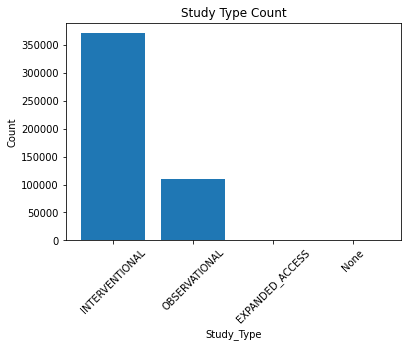

In [0]:
def RDD_SC2_Study_Type_Freq():
    
    rdd2=Final_rdd.map(lambda x: ( x[10].strip() ,x[0]))\
                  .groupByKey()\
                  .mapValues(lambda x : len(x))\
                  .sortBy(lambda a: -a[1])\
                  .collect()

    rdd2=sc.parallelize(rdd2)
    columns=["Study_Type" ,"Count"]
    df=rdd2.toDF(columns).replace('','None')
    df.show(truncate=False)

    df = df.toPandas()

    x = df['Study_Type']
    y = df['Count']

    fig, ax = plt.subplots()
    ax.bar(x, y)
    plt.xlabel('Study_Type')
    plt.ylabel('Count')
    plt.title('Study Type Count')
    plt.xticks(rotation = 45)
    plt.show()

RDD_SC2_Study_Type_Freq()

Scenario 3 - The top 5 conditions (from Conditions) with their frequencies.

+-------------+-----------+
|Conditions   |Frequencies|
+-------------+-----------+
|Healthy      |9731       |
|Breast Cancer|7502       |
|Obesity      |6549       |
|Stroke       |4073       |
|Hypertension |4024       |
+-------------+-----------+



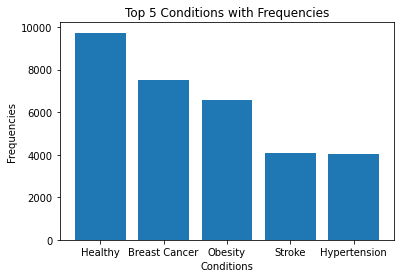

In [0]:
def RDD_SC3_Conditions_Top5():

    rdd3=Final_rdd.filter(lambda x : x[4] is not None)\
                  .filter(lambda x : x[4] != '')\
                  .filter(lambda x : x[4].lower() != 'null')\
                  .map(lambda x: (x[0], x[4].split('|')))\
                  .flatMap(lambda x : [(x[0] , cond) for cond in x[1]])\
                  .map(lambda x : (x[1],x[0]))\
                  .groupByKey()\
                  .mapValues(lambda x : len(x))\
                  .sortBy(lambda a: -a[1])\
                  .collect()
             
    rdd3=sc.parallelize(rdd3).take(5)
    rdd3=sc.parallelize(rdd3)
    columns=["Conditions","Frequencies"]
    df=rdd3.toDF(columns)
    df.show(truncate=False)
    
    df = df.toPandas()

    x = df['Conditions']
    y = df['Frequencies']

    fig, ax = plt.subplots()
    ax.bar(x, y)
    plt.xlabel('Conditions')
    plt.ylabel('Frequencies')
    plt.title('Top 5 Conditions with Frequencies')
    plt.show()

RDD_SC3_Conditions_Top5()

Scenario 4 - Find the 10 most common sponsors that are not pharmaceutical companies, along with the number of clinical trials they have sponsored.

+-------------------------------------------------------------+-------------+
|Sponsor_Non_Pharma                                           |Sponsor_Count|
+-------------------------------------------------------------+-------------+
|National Cancer Institute (NCI)                              |3410         |
|Assiut University                                            |3335         |
|Cairo University                                             |3023         |
|Assistance Publique - Hôpitaux de Paris                      |2951         |
|Mayo Clinic                                                  |2766         |
|M.D. Anderson Cancer Center                                  |2702         |
|Novartis Pharmaceuticals                                     |2393         |
|National Institute of Allergy and Infectious Diseases (NIAID)|2340         |
|Massachusetts General Hospital                               |2263         |
|National Taiwan University Hospital                          |2

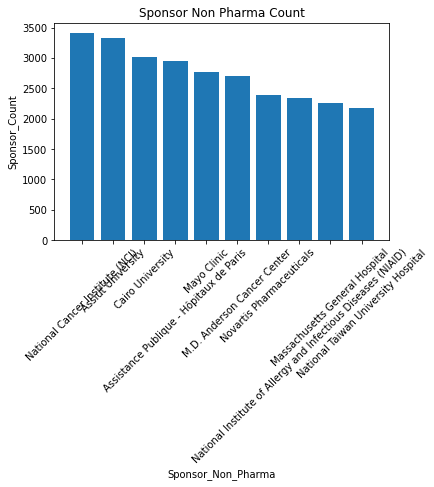

<Figure size 720x720 with 0 Axes>

In [0]:
def RDD_SC4_Sponsors_clinical_trials():
    rdd4=Final_rdd.map(lambda x: ( x[6].strip() ,x[0]))\
                  .groupByKey()\
                  .mapValues(lambda x : len(set(x)))\
                  .sortBy(lambda a: -a[1])\
                   .collect()

    rdd1_Pharma=df_Pharma_rdd.map(lambda x: ( x[1].strip() ,x[0:]))\
                            .groupByKey()\
                            .mapValues(lambda x : len(set(x)))\
                            .sortBy(lambda a: -a[1])\
                            .collect()

    rdd4=sc.parallelize(rdd4)
    rdd1_Pharma=sc.parallelize(rdd1_Pharma)

    join=rdd4.subtractByKey(rdd1_Pharma)\
             .sortBy(lambda a: -a[1])\
             .collect()

    join=sc.parallelize(join).take(10)

    rd=sc.parallelize(join)
    cols=["Sponsor_Non_Pharma" ,"Sponsor_Count"]
    df4=rd.toDF(cols)
    df4.show(truncate=False)

    df4 = df4.toPandas()

    x = df4['Sponsor_Non_Pharma']
    y = df4['Sponsor_Count']

    fig, ax = plt.subplots()
    ax.bar(x, y)
    plt.xlabel('Sponsor_Non_Pharma')
    plt.ylabel('Sponsor_Count')
    plt.title('Sponsor Non Pharma Count')
    plt.xticks(rotation = 45)
    plt.figure(figsize=(10,10))
    plt.show()
RDD_SC4_Sponsors_clinical_trials()

Scenario 5 - Plot number of completed studies for each month in 2023. You need to include your visualization as well as a table of all the values you have plotted for each month.

+-----+-----------+
|Month|Trial_Count|
+-----+-----------+
|01   |1494       |
|02   |1272       |
|03   |1552       |
|04   |1324       |
|05   |1415       |
|06   |1619       |
|07   |1360       |
|08   |1230       |
|09   |1152       |
|10   |1058       |
|11   |909        |
|12   |1082       |
+-----+-----------+



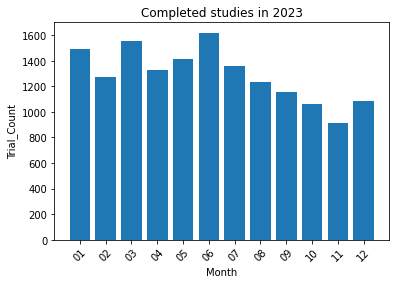

In [0]:
def RDD_SC5_CompletedStudies_2023():

    rdd5=Final_rdd.filter(lambda x : x[3].lower().strip() == 'completed')\
                  .filter(lambda x : x[13] is not None)\
                  .filter(lambda x : x[13] != '')\
                  .filter(lambda x : x[13].lower() != 'null')\
                  .filter(lambda x : (x[13].split('-')[0]=='2023'))\
                  .map(lambda x : (x[13].strip().split('-')[1],x[0]))\
                  .groupByKey()\
                  .mapValues(lambda x : len(set(x)))\
                  .sortBy(lambda a: a[0])\
                  .collect()
    
    rdd5_0=sc.parallelize(rdd5)
    columns=["Month","Trial_Count"]
    df5=rdd5_0.toDF(columns)
    df5.show(truncate=False)

    df5 = df5.toPandas()

    x = df5['Month']
    y = df5['Trial_Count']

    fig, ax = plt.subplots()
    ax.bar(x, y)
    plt.xlabel('Month')
    plt.ylabel('Trial_Count')
    plt.title('Completed studies in 2023')
    plt.xticks(rotation = 45)
    plt.show()

RDD_SC5_CompletedStudies_2023()

Additional Scenario - To find all status wise trial count for 2023

+-----------------------+-----------+
|Status                 |Trial_Count|
+-----------------------+-----------+
|COMPLETED              |15467      |
|RECRUITING             |8914       |
|UNKNOWN                |4984       |
|ACTIVE_NOT_RECRUITING  |3888       |
|NOT_YET_RECRUITING     |2318       |
|TERMINATED             |1460       |
|WITHDRAWN              |962        |
|ENROLLING_BY_INVITATION|652        |
|SUSPENDED              |182        |
+-----------------------+-----------+



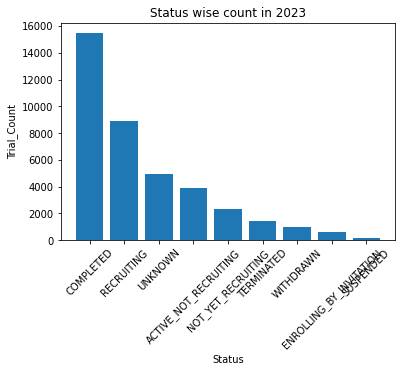

In [0]:
def RDD_ADD1_Status_wise_Count_2023():

    rdd6=Final_rdd.filter(lambda x : (x[13].split('-')[0]=='2023'))\
                  .map(lambda x : (x[3],x[0]))\
                  .groupByKey()\
                  .mapValues(lambda x : len(set(x)))\
                  .sortBy(lambda a: -a[1])\
                  .collect()

    rdd6=sc.parallelize(rdd6)
    columns=["Status","Trial_Count"]
    df6=rdd6.toDF(columns)
    df6.show(truncate=False)

    df6 = df6.toPandas()

    x = df6['Status']
    y = df6['Trial_Count']

    fig, ax = plt.subplots()
    ax.bar(x, y)
    plt.xlabel('Status')
    plt.ylabel('Trial_Count')
    plt.title('Status wise count in 2023')
    plt.xticks(rotation = 45)
    plt.show()

RDD_ADD1_Status_wise_Count_2023()

Additional Scenario - Least 5 sponsor

In [0]:
def RDD_ADD2_Least_5_Sponsors():

    rdd7=Final_rdd.map(lambda x: ( x[6].strip() ,x[0]))\
                  .groupByKey()\
                  .mapValues(lambda x : len(set(x)))\
                  .sortBy(lambda a: a[1])\
                  .collect()

    display(rdd7)

    rdd7=sc.parallelize(rdd7).take(4)

RDD_ADD2_Least_5_Sponsors()

_1,_2
Zhongzheng Xiang,1
Enox Israel Ltd,1
Hanan Nabil,1
Mitsubishi Tanabe Pharma GmbH,1
David Barbic,1
RehaClinic AG,1
Gero Bunniger,1
Cem Ilgin Erol,1
Tomasz Romańczyk,1
Enos Bernasconi,1
